# Experiments for the DPT model


In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import random_split, DataLoader

from hubmap.models.dpt import DPT
from hubmap.losses.bce_dice_loss import BCEDiceLoss

from hubmap.data import DATA_DIR
from hubmap.dataset.datasets import BaseDataset, ExpertDataset, DatasetFromSubset
from hubmap.dataset import transforms as T

In [2]:
transforms_train = T.Compose([
    T.ToTensor(),
    T.Resize((512, 512)),
    # T.RandomHorizontalFlip(),
    # T.RandomVerticalFlip(),
    # T.RandomGamma(), # aufpassen, die default values sind nicht gut
    # T.RandomHueSaturationValue(), # aufpassen, die default values sind nicht gut
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [3]:
transforms_val = T.Compose([
    T.ToTensor(),
    T.Resize((512, 512)),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [18]:
dataset = ExpertDataset(DATA_DIR)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset_sub, test_dataset_sub = random_split(dataset, [train_size, test_size])

train_dataset = DatasetFromSubset(train_dataset_sub, transform=transforms_train)
test_dataset = DatasetFromSubset(test_dataset_sub, transform=transforms_val)

In [19]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
model = DPT(num_classes=3, features=128)
model = model.to(device)

In [35]:
criterion = BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
train_losses = train_accs = []
val_losses = val_accs = []

In [37]:
n_epochs = 10

In [38]:
for epoch in range(n_epochs):
    train_batch_losses = train_batch_accs = []
    model.train()
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(images)

        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        
        # acc = calculate_segmentation_accuracy(
        #     preds.detach(), targets.detach(), device
        # )

        train_batch_losses.append(loss.item())
        # train_batch_accs.append(acc.item())

    val_batch_losses = val_batch_accs = []
    model.eval()
    for images, targets in test_loader:
        images = images.to(device)
        
        targets = targets.to(device)
                
        with torch.no_grad():
            preds = model(images)
            loss = criterion(preds, targets)
            
            # acc = calculate_segmentation_accuracy(
            #     preds.detach(), targets.detach(), device
            # )
        
        val_batch_losses.append(loss.item())
        # val_batch_accs.append(acc.item())
    
    train_losses.append(np.mean(train_batch_losses))
    # train_accs.append(np.mean(train_batch_accs))
    val_losses.append(np.mean(val_batch_losses))
    # val_accs.append(np.mean(val_batch_accs))
    
    print(
        f"Epoch {epoch+1}/{n_epochs} | "
        f"Train: Loss = {np.mean(train_batch_losses):.6f} | "
        # f"- Accuracy = {(np.mean(train_batch_accs) * 100):.2f}% | "
        f"Val: Loss = {np.mean(val_batch_losses):.6f}"  # | "
        # f"- Accuracy = {(np.mean(val_batch_accs) * 100):.2f}%"
    )

Epoch 1/10 | Train: Loss = 1.244524 | Val: Loss = 1.275873
Epoch 2/10 | Train: Loss = 1.103610 | Val: Loss = 1.257341
Epoch 3/10 | Train: Loss = 0.997919 | Val: Loss = 1.282546
Epoch 4/10 | Train: Loss = 0.844863 | Val: Loss = 1.038984
Epoch 5/10 | Train: Loss = 0.796686 | Val: Loss = 0.905934
Epoch 6/10 | Train: Loss = 0.770193 | Val: Loss = 0.988057
Epoch 7/10 | Train: Loss = 0.747237 | Val: Loss = 1.088986
Epoch 8/10 | Train: Loss = 0.773749 | Val: Loss = 0.842383
Epoch 9/10 | Train: Loss = 0.734577 | Val: Loss = 0.770671
Epoch 10/10 | Train: Loss = 0.728510 | Val: Loss = 0.908311


Text(0.5, 0.98, 'Training And Validation Loss of DPT')

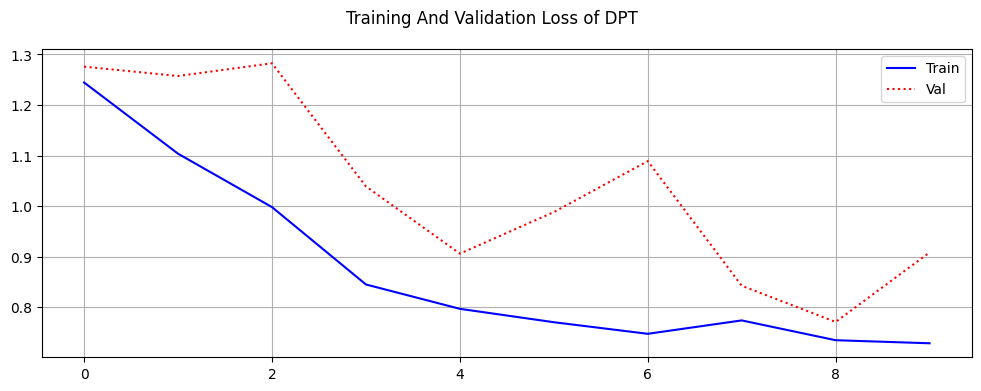

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

axs.grid()
sns.lineplot(train_losses, color="blue", linestyle="solid", label="Train")
sns.lineplot(val_losses, color="red", linestyle="dotted", label="Val")
fig.suptitle("Training And Validation Loss of DPT")